# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156225 sha256=6eba39fd3a2815fd35b0514ea5c2b513bacbdfd1f05389c56afde6f53ee01b02
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

###################################################
# Label encoding
from sklearn.preprocessing import LabelEncoder
###################################################

# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing play_counts, data should be in structure - user; item ; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold


# For implementing clustering based recommendation system
from surprise import CoClustering
###################################################


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
#define column names
column_names=['user_id', 'prod_id', 'rating', 'timestamp']
#load data from csv file to panda dataframe
ratings_electronics_df = pd.read_csv('/content/drive/MyDrive/machine_learning_mit/Module 6 - Recommendation Systems/Project/ratings_Electronics.csv', names=column_names)
#drop column timestamp
ratings_electronics_df = ratings_electronics_df.drop(['timestamp'],axis=1)
#Copy the data to another DataFrame called df
df = ratings_electronics_df.copy()

#print out first 5 rows of the data frame ratings_electronics_df and df
print("-" * 10)
print(ratings_electronics_df.head())
print("-" * 10)
print(df.head())
print("-" * 10)
print(ratings_electronics_df.shape)




----------
          user_id     prod_id  rating
0   AKM1MP6P0OYPR  0132793040     5.0
1  A2CX7LUOHB2NDG  0321732944     5.0
2  A2NWSAGRHCP8N5  0439886341     1.0
3  A2WNBOD3WNDNKT  0439886341     3.0
4  A1GI0U4ZRJA8WN  0439886341     1.0
----------
          user_id     prod_id  rating
0   AKM1MP6P0OYPR  0132793040     5.0
1  A2CX7LUOHB2NDG  0321732944     5.0
2  A2NWSAGRHCP8N5  0439886341     1.0
3  A2WNBOD3WNDNKT  0439886341     3.0
4  A1GI0U4ZRJA8WN  0439886341     1.0
----------
(7824482, 3)


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [5]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [6]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [7]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [8]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [9]:
# Print a few rows of the imported dataset
df_final=df_final.reset_index(drop=True)
#df_final=df_final.drop(['index'],axis=1)
df_final.head()

,user_id,prod_id,rating
0,A3LDPF5FMB782Z,1400501466,5.0
1,A1A5KUIIIHFF4U,1400501466,1.0
2,A2XIOXRRYX0KZY,1400501466,3.0
3,AW3LX47IHPFRL,1400501466,5.0
4,A1E3OB6QMBKRYZ,1400501466,1.0


In [18]:
df_final.shape

(65290, 3)

## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [10]:
# Check the number of rows and columns and provide observations
df_final.shape



(65290, 3)

**Write your observations here:**

There are 65290 rows and 3 columns


### **Data types**

In [11]:
# Check Data types and provide observations
df_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65290 entries, 0 to 65289
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB


**Write your observations here:**

1) user_id and prod_id are of type string.

2) rating is floating point value which is of type float64.





### **Checking for missing values**

In [12]:
# Check for missing values present and provide observations
missing_values = df_final.isna()
#check missing value of user_id
print(missing_values['user_id'].value_counts())
#check missing value of prod_id
print(missing_values['prod_id'].value_counts())
#check missing value of rating
print(missing_values['rating'].value_counts())



False    65290
Name: user_id, dtype: int64
False    65290
Name: prod_id, dtype: int64
False    65290
Name: rating, dtype: int64


**Write your observations here:**

From the printing above, there are no missing values here.

### **Summary Statistics**

In [13]:
# Summary statistics of 'rating' variable and provide observations
#df_final['rating']
#print mean rating
print(round(df_final['rating'].mean(),3))
#print median rating
print(df_final['rating'].median())
#print min rating
print(df_final['rating'].min())
#print max rating
print(df_final['rating'].max())




4.295
5.0
1.0
5.0


**Write your observations here:**

Mean rating = 4.295

Median rating = 5.0

Min rating = 1.0

Max rating = 5.0


### **Checking the rating distribution**

   rating  counts
0     5.0   36315
1     4.0   18127
2     3.0    6481
3     2.0    2515
4     1.0    1852


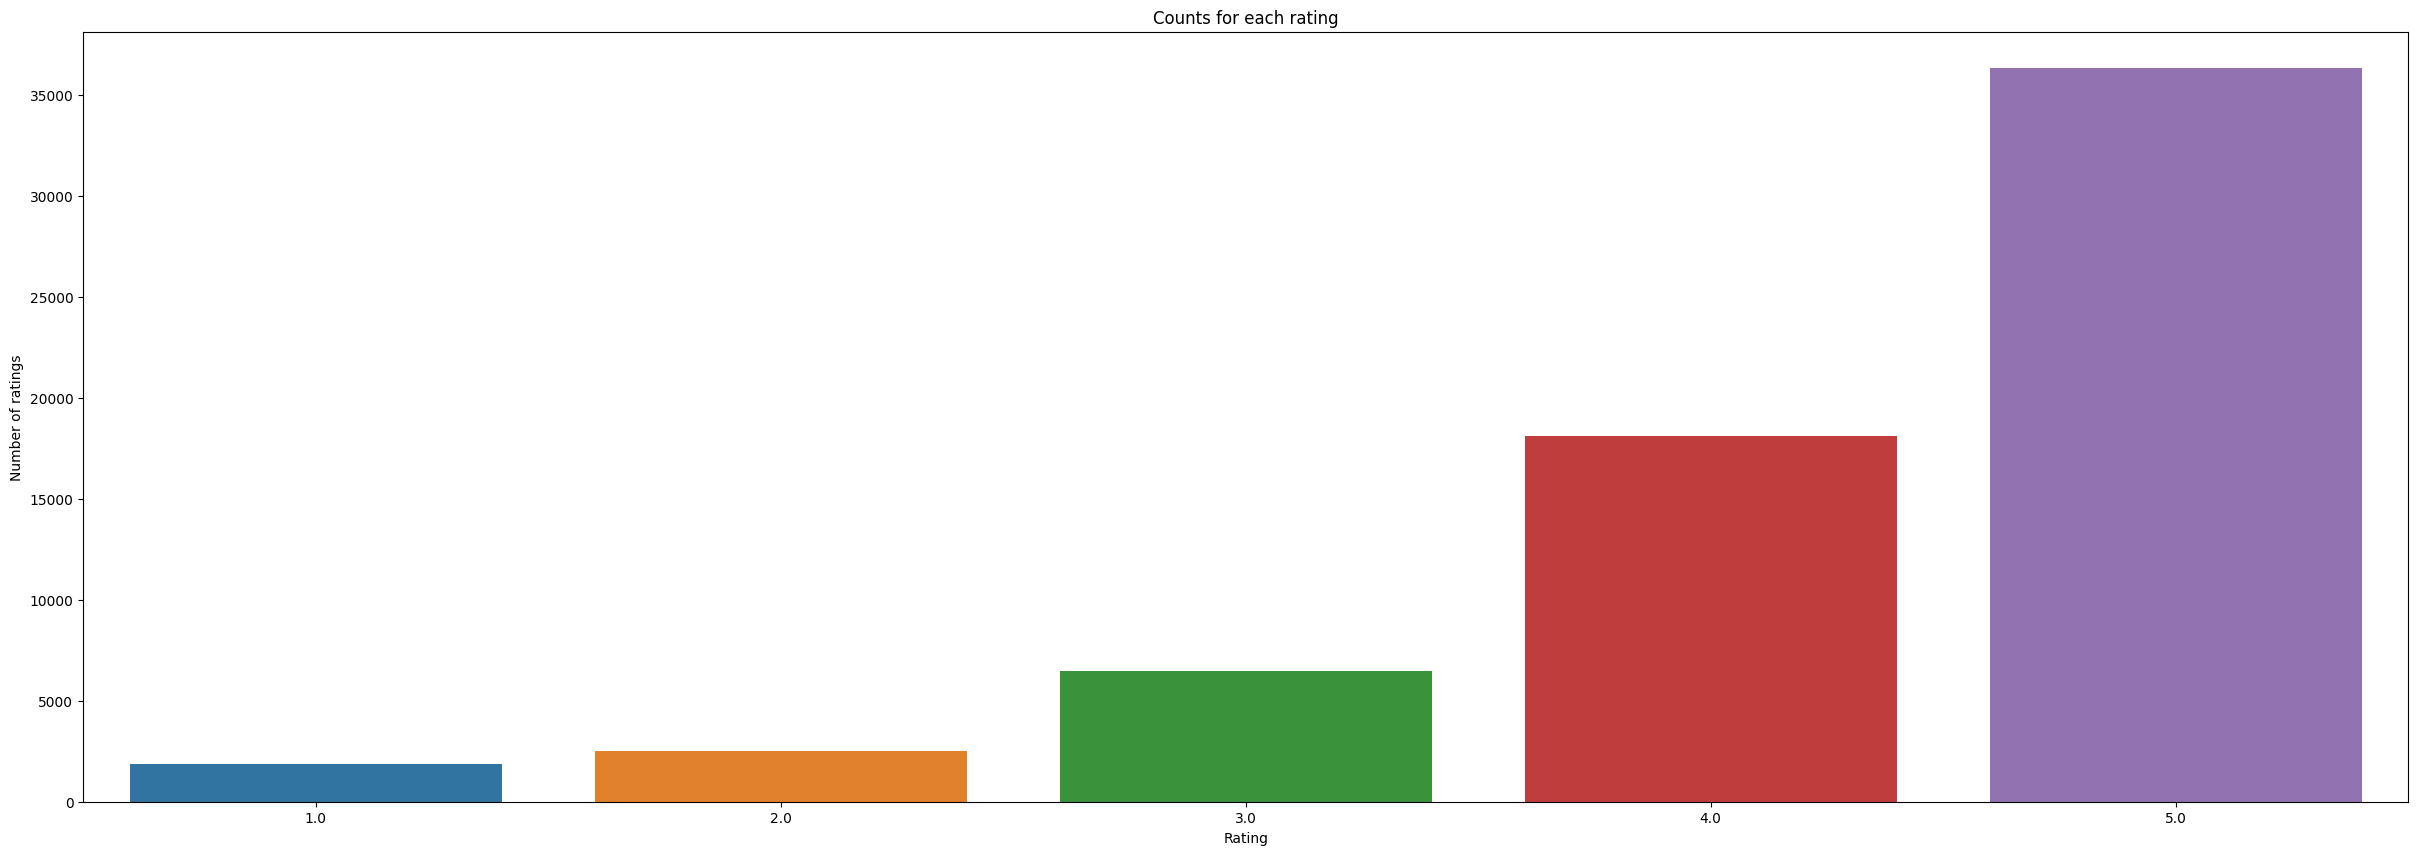

In [48]:
# Create the bar plot and provide observations
rating_counts=df_final['rating'].value_counts().rename_axis('rating').reset_index(name='counts')
print(rating_counts)

plt.figure(figsize=(30,10))
sns.barplot(x = rating_counts.rating,
            y = rating_counts.counts,
            data = rating_counts,
            estimator = np.median)
plt.ylabel('Number of ratings')
plt.xlabel('Rating')
plt.title('Counts for each rating')
# Show the plot
plt.show()



**Write your observations here:________**

We can see that rating 5 has highest count which is 36315,

rating 4 has second highest count which is 18127,

rating 3 has third highest count which is 6481,

rating 2 has fourth highest count which is 2515,

rating 1 has lowest count which is 1852.

In short, the higher the rating, the more count for that rating, vice versa.




### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
print(df_final['user_id'].nunique())
print(df_final['prod_id'].nunique())


1540
5689


**Write your observations here:**

Number of unique users = 1540

Number of unique products = 5689



### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final_rating=df_final.groupby('user_id').count()['rating']
#print("-" * 18)
#print(df_final_rating)
#print("-" * 18)
df_final_rating=pd.DataFrame({'rating':df_final_rating})
#print("-" * 18)
#print(df_final_rating)
#print("-" * 18)
df_final_rating_sorted = df_final_rating.sort_values(by='rating', ascending=False)
#print("-" * 18)
print(df_final_rating_sorted.head(10))

#print(df_final)




                rating
user_id               
ADLVFFE4VBT8       295
A3OXHLG6DIBRW8     230
A1ODOGXEYECQQ8     217
A36K2N527TXXJN     212
A25C2M3QF9G7OQ     203
A680RUE1FDO8B      196
A22CW0ZHY3NJH8     193
A1UQBFCERIP7VJ     193
AWPODHOB4GFWL      184
A3LGT6UZL99IW1     179


**Write your observations here:**

From the results above, we get the top ten users with most number of ratings as

below:

user_id                     number of ratings

ADLVFFE4VBT8                295

A3OXHLG6DIBRW8              230

A1ODOGXEYECQQ8              217

A36K2N527TXXJN              212

A25C2M3QF9G7OQ              203

A680RUE1FDO8B               196

A22CW0ZHY3NJH8              193

A1UQBFCERIP7VJ              193

AWPODHOB4GFWL               184

A3LGT6UZL99IW1              179




**Now that we have explored and prepared the data, let's build the first
recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating_for_each_product = df_final.groupby('prod_id').mean()['rating']
print("-" * 18)
print(average_rating_for_each_product)
print("-" * 18)
# Calculate the count of ratings for each product
count_of_ratings_for_each_product=df_final.groupby('prod_id').count()['rating']
print(count_of_ratings_for_each_product)
print("-" * 18)
# Create a dataframe with calculated average and count of ratings
df_with_calculated_average_and_count_of_ratings = pd.DataFrame({'avg_rating_for_each_product':average_rating_for_each_product, 'count_of_ratings_for_each_product':count_of_ratings_for_each_product})

# Sort the dataframe by average of ratings in the descending order
df_with_calculated_average_and_count_of_ratings_sort_by_avg_rating=df_with_calculated_average_and_count_of_ratings.sort_values(by='avg_rating_for_each_product', ascending=False)
df_with_calculated_average_and_count_of_ratings_sort_by_count_of__rating=df_with_calculated_average_and_count_of_ratings.sort_values(by='count_of_ratings_for_each_product', ascending=False)
#df_with_calculated_average_and_count_of_ratings.sort_values(by='avg_rating_for_each_product', ascending=False,  inplace=True)
# See the first five records of the "final_rating" dataset
print(df_with_calculated_average_and_count_of_ratings_sort_by_avg_rating.head(5))
print("-" * 18)
print(df_with_calculated_average_and_count_of_ratings_sort_by_count_of__rating.head(5))
print("-" * 18)
df_with_calculated_average_and_count_of_ratings=df_with_calculated_average_and_count_of_ratings_sort_by_avg_rating
print(df_with_calculated_average_and_count_of_ratings)


------------------
prod_id
1400501466    3.333333
1400532655    3.833333
1400599997    4.000000
9983891212    4.875000
B00000DM9W    5.000000
                ...   
B00L21HC7A    4.625000
B00L2442H0    4.916667
B00L26YDA4    4.384615
B00L3YHF6O    5.000000
B00LGQ6HL8    5.000000
Name: rating, Length: 5689, dtype: float64
------------------
prod_id
1400501466     6
1400532655     6
1400599997     5
9983891212     8
B00000DM9W     5
              ..
B00L21HC7A    16
B00L2442H0    12
B00L26YDA4    13
B00L3YHF6O    14
B00LGQ6HL8     5
Name: rating, Length: 5689, dtype: int64
------------------
            avg_rating_for_each_product  count_of_ratings_for_each_product
prod_id                                                                   
B00LGQ6HL8                          5.0                                  5
B003DZJQQI                          5.0                                 14
B005FDXF2C                          5.0                                  7
B00I6CVPVC                  

In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
#min_interactions means count_of_ratings_for_each_product
def top_n_products(data, n, min_interactions=50):

    # Finding products with minimum number of interactions
    recommendations = data[data['count_of_ratings_for_each_product'] >= min_interactions]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='avg_rating_for_each_product', ascending=False)

    return recommendations.index[:n]



### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
print("Top 5 products with 50 minimum interactions based on popularity recommended:")
product_list_recommended=list(top_n_products(df_with_calculated_average_and_count_of_ratings, 5, 50))
for product in product_list_recommended:
   print(product)


Top 5 products with 50 minimum interactions based on popularity recommended:
B001TH7GUU
B003ES5ZUU
B0019EHU8G
B006W8U2MU
B000QUUFRW


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
print("Top 5 products with 100 minimum interactions based on popularity recommended:")
product_list_recommended=list(top_n_products(df_with_calculated_average_and_count_of_ratings, 5, 100))
for product in product_list_recommended:
   print(product)


Top 5 products with 100 minimum interactions based on popularity recommended:
B003ES5ZUU
B000N99BBC
B002WE6D44
B007WTAJTO
B002V88HFE


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.40, random_state=42)


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)



RMSE: 1.0347
Precision:  0.867
Recall:  0.7
F_1 score:  0.775


**Write your observations here:**

We have calculated RMSE to check how far the overall predicted ratings are from the actual ratings.

Intuition of Recall - We are getting a recall of almost 0.70, which means out of all the relevant products, 70% are recommended.

Intuition of Precision - We are getting a precision of almost 0.867, which means out of all the recommended products, 86.7% are relevant.

Here F_1 score of the baseline model is almost 0.775. It indicates that mostly recommended products were relevant and relevant products were recommended. We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.








Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)
#(df_final['prod_id']=='1400501466').value_counts()
#(df_final['user_id']=='A3LDPF5FMB782Z').value_counts()




user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Write your observations here:__________**

The above output shows that the actual rating for this user-item pair is 5 and the predicted is 3.0 by this user-user-similarity-based baseline model.


Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
#df_final.shape
#df_final[df_final['prod_id']=='1400501466']
list_of_users_who_have_not_seen_the_product_with_product_id_1400501466=df_final[df_final['prod_id']!='1400501466']['user_id']
list_of_users_who_have_not_seen_the_product_with_product_id_1400501466=list_of_users_who_have_not_seen_the_product_with_product_id_1400501466.unique()
print("list of users who have not seen the product with product id 1400501466:")
print(list_of_users_who_have_not_seen_the_product_with_product_id_1400501466)

#for users_who_have_not_seen_the_product_with_product_id_1400501466 in list_of_users_who_have_not_seen_the_product_with_product_id_1400501466:
#  print(users_who_have_not_seen_the_product_with_product_id_1400501466)

print("\n")

if 'A34BZM6S9L7QI4' in list_of_users_who_have_not_seen_the_product_with_product_id_1400501466:
   print("User A34BZM6S9L7QI4 has NOT seen the product with productId 1400501466")

print("\n")
print("number of users who have not seen the product with product id 1400501466 = " + str(list_of_users_who_have_not_seen_the_product_with_product_id_1400501466.shape[0]))



list of users who have not seen the product with product id 1400501466:
['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


User A34BZM6S9L7QI4 has NOT seen the product with productId 1400501466


number of users who have not seen the product with product id 1400501466 = 1540


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)



user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:__________**

As we can see the predicted rating for this user-item pair is 4.29 based on this user-user-similarity-based baseline model.



### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40, 50], 'min_k': [1, 2, 3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])




0.9798125944123955
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True, "min_support":2}


#sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=3, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)




RMSE: 0.9763
Precision:  0.845
Recall:  0.705
F_1 score:  0.769


**Write your observations here:__________**

We can see from above that after tuning hyperparameters, F_1 score of the tuned model is slightly less than the baseline model (from 0.775 to 0.769). Along with this the RMSE of the model has gone down as compared to the model before hyperparameter tuning (reduced from 1.0347 to 0.9763). Precision is reduced from 0.867 to 0.845 but recall is increased from 0.7 to 0.705. Hence, we can say that the model performance has improved after hyperparameter tuning.



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)



user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)



user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**____________

For the prediction of userId "A3LDPF5FMB782Z" and productId 1400501466

by the tuned model sim_user_user_optimized, we got the above output which shows that

the actual rating for this user-item pair is 5 and the predicted is 4.29 by

this optimized user-user-similarity-based baseline model, which is more

accurate than the previous predicted value 3.0 of the model without tuning.

For  userId "A34BZM6S9L7QI4" and productId "1400501466", we got result

of predicted value 4.29 which is same as before without tuning.




### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user

neighbour_of_user=sim_user_user.get_neighbors(0,5) # Here 0 is the inner id of the above user.
neighbour_of_user_optimized=sim_user_user_optimized.get_neighbors(0,5) # Here 0 is the inner id of the above user.

print("With user-user similarity based model, the 5 most similar users to the first user in the list with internal id 0, based on the msd distance metric as below:")
print(neighbour_of_user)
print("\n")
print("With optimized user-user similarity based model, the 5 most similar users to the first user in the list with internal id 0, based on the msd distance metric as below:")
print(neighbour_of_user_optimized)




With user-user similarity based model, the 5 most similar users to the first user in the list with internal id 0, based on the msd distance metric as below:
[7, 11, 12, 16, 26]


With optimized user-user similarity based model, the 5 most similar users to the first user in the list with internal id 0, based on the msd distance metric as below:
[33, 49, 54, 71, 113]


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
#sim_user_user_optimized
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
print("-"*18)
recommendations = get_recommendations(df_final,'A3LDPF5FMB782Z', 5, sim_user_user)
print("Below are top 5 products for userId = \"A3LDPF5FMB782Z\" with similarity based recommendation system")
print(recommendations)
print("-"*18)
print("-"*18)
recommendations_optimized = get_recommendations(df_final,'A3LDPF5FMB782Z', 5, sim_user_user_optimized)
print("Below are top 5 products for userId = \"A3LDPF5FMB782Z\" with optimized similarity based recommendation system")
print(recommendations_optimized)



------------------
Below are top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system
[('B00001W0DI', 5), ('B00002EQCW', 5), ('B00003006R', 5), ('B00004W3ZQ', 5), ('B00004WCFT', 5)]
------------------
------------------
Below are top 5 products for userId = "A3LDPF5FMB782Z" with optimized similarity based recommendation system
[('1400532655', 4.2901924746005005), ('1400599997', 4.2901924746005005), ('9983891212', 4.2901924746005005), ('B00000DM9W', 4.2901924746005005), ('B00000J1V5', 4.2901924746005005)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
df_recommended=pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
df_recommended_op=pd.DataFrame(recommendations_optimized, columns=['prod_id', 'predicted_ratings'])
print("Below are top 5 products for userId = \"A3LDPF5FMB782Z\" with user-user based similarity based recommendation system")
print(df_recommended)
print("-" * 18)
print("Below are top 5 products for userId = \"A3LDPF5FMB782Z\" with optimized user-user based similarity based recommendation system")
print(df_recommended_op)



Below are top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system
      prod_id  predicted_ratings
0  B00001W0DI                  5
1  B00002EQCW                  5
2  B00003006R                  5
3  B00004W3ZQ                  5
4  B00004WCFT                  5
------------------
Below are top 5 products for userId = "A3LDPF5FMB782Z" with optimized similarity based recommendation system
      prod_id  predicted_ratings
0  1400532655           4.290192
1  1400599997           4.290192
2  9983891212           4.290192
3  B00000DM9W           4.290192
4  B00000J1V5           4.290192


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options

sim_options = {'name': 'pearson',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)


RMSE: 1.0232
Precision:  0.834
Recall:  0.699
F_1 score:  0.761


**Write your observations here:**____________

The baseline model is giving a good F_1 score 0.761. We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.



Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=5, details={'actual_k': 1, 'was_impossible': False})

**Write your observations here:**____________

The above output shows that item-item similarity based model is making a very good prediction with predicted value equal 5 where the actual value is 5.
The predicted value is more accurate than the value predicted by user-user similarity based model for same user-item pair, where the predicted value is 3.


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product

sim_item_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**____________

As we can see the predicted rating for this user-product pair is 4.29 based on this item-item similarity-based baseline model which is same prediction value
as the one predicted by user-user similarity-based baseline model.



### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters

param_grid = {'k': [10, 20, 30, 40], 'min_k': [1,2, 3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [False], "min_support":[2,4]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



0.9851508404323979
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': False, 'min_support': 2}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering

sim_options = {'name': 'cosine',
               'user_based': False, "min_support":2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=20, min_k=6, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)




RMSE: 0.9815
Precision:  0.832
Recall:  0.699
F_1 score:  0.76


**Write your observations here:__________**

RMSE got reduced from 1.0232 to 0.9815 and the rest of parameters almost

unchanged. We can say that the tuned item-item model is better than the

item-item model without tuning.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
#df_final['user_id'][(df_final['prod_id']=='1400501466')]
#df_final['rating'][(df_final['prod_id']=='1400501466')]
print(df_final[(df_final['prod_id']=='1400501466') & (df_final['user_id']=='A3LDPF5FMB782Z')])
print("-" * 18)
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)




          user_id     prod_id  rating
0  A3LDPF5FMB782Z  1400501466     5.0
------------------
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"

print(df_final[(df_final['prod_id']=='1400501466') & (df_final['user_id']=='A34BZM6S9L7QI4')])
print("-" * 18)
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)





Empty DataFrame
Columns: [user_id, prod_id, rating]
Index: []
------------------
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.2901924746005005, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:__________**

For the user-item pair A3LDPF5FMB782Z and 1400501466 with known actual value of

5, after tuning, the predicted value is 4.29 but it is less accurate than the

predicted value 5 by the model without tuning for the same user-item pair.


For the user-item pair A34BZM6S9L7QI4 and 1400501466 with unknown actual value,

after tuning, the predicted value is 4.29 which is same as the value predicted

by the model without tuning for the same user-item pair.




### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
neighbour_of_user=sim_item_item.get_neighbors(0, k=5)
neighbour_of_user_optimized=sim_item_item_optimized.get_neighbors(0, k=5)

print("With item-item similarity-based model, below we are finding the 5 most similar items to the item with internal id 0 based on the msd distance metric:")
print(neighbour_of_user)
print("\n")
print("With optimzied item-item similarity-based model, below we are finding the 5 most similar items to the item with internal id 0 based on the msd distance metric:")
print(neighbour_of_user_optimized)




With item-item similarity-based model, below we are finding the 5 most similar items to the item with internal id 0 based on the msd distance metric:
[534, 761, 1703, 1786, 1]


With optimzied item-item similarity-based model, below we are finding the 5 most similar items to the item with internal id 0 based on the msd distance metric:
[315, 1201, 761, 1703, 1786]


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item)
recommendations_optimized = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)
print("Predicting top 5 products for userId = \"A1A5KUIIIHFF4U\" with item-item similarity based recommendation system:")
print(recommendations)
print("\n")
print("Predicting top 5 products for userId = \"A1A5KUIIIHFF4U\" with optimized item-item similarity based recommendation system:")
print(recommendations_optimized)





Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with item-item similarity based recommendation system:
[('1400532655', 4.2901924746005005), ('1400599997', 4.2901924746005005), ('9983891212', 4.2901924746005005), ('B00000DM9W', 4.2901924746005005), ('B00000J1V5', 4.2901924746005005)]


Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with optimized item-item similarity based recommendation system:
[('1400532655', 4.2901924746005005), ('1400599997', 4.2901924746005005), ('9983891212', 4.2901924746005005), ('B00000DM9W', 4.2901924746005005), ('B00000J1V5', 4.2901924746005005)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
df_recommended = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_rating'])
df_recommended_op = pd.DataFrame(recommendations_optimized, columns=['prod_id', 'predicted_rating'])

print("Below are top 5 products for userId = \"A3LDPF5FMB782Z\" with item-item based similarity based recommendation system")
print(df_recommended)
print("-" * 18)
print("Below are top 5 products for userId = \"A3LDPF5FMB782Z\" with optimized item-item based similarity based recommendation system")
print(df_recommended_op)






Below are top 5 products for userId = "A3LDPF5FMB782Z" with item-item based similarity based recommendation system
      prod_id  predicted_rating
0  1400532655          4.290192
1  1400599997          4.290192
2  9983891212          4.290192
3  B00000DM9W          4.290192
4  B00000J1V5          4.290192
------------------
Below are top 5 products for userId = "A3LDPF5FMB782Z" with optimized item-item based similarity based recommendation system
      prod_id  predicted_rating
0  1400532655          4.290192
1  1400599997          4.290192
2  9983891212          4.290192
3  B00000DM9W          4.290192
4  B00000J1V5          4.290192


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.9032
Precision:  0.87
Recall:  0.708
F_1 score:  0.781


**Write your observations here:___________**

The "Model-Based Collaborative Filtering - Matrix Factorization" model with the

algorithm is giving a nice F-1 score 78.1%, with high precision 0.87 and recall

0.708 respectively. RMSE is 0.9032. It indicates a good performance by the

model.



**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction

svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)



user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.084585882575799, details={'was_impossible': False})

**Write your observations here:___________**

As we can see - the actual rating for this user-product pair is 5 and the

predicted rating is 4.08 by this matrix factorization-based baseline model.

It seems like we have under-estimated the rating. We will try to fix this later

by tuning the hyperparameters of the model using GridSearchCV



**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction

svd.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)




user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.11   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.107707909926497, details={'was_impossible': False})

**Write your observations here:___________**

We can see that the estimated rating for this user-product pair is 4.11 based

on this matrix factorization based baseline model.



### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30, 40, 50], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])




0.9000684285303812
{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=40, lr_all=0.005, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)


RMSE: 0.8940
Precision:  0.875
Recall:  0.706
F_1 score:  0.781


**Write your observations here:_____________**

After tuning, the F1 score is unchanged, recall is slightly decreased from

0.708 to 0.706, precision is slightly increased from 0.87 to 0.875, RMSE

slightly reduced from 0.9032 to 0.8940. We may say that the model without tuning

almost same performance as the model after tuning.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.12   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.115185374508074, details={'was_impossible': False})

Here the predicted rating is 4.12 for a product whose actual rating is 5.



In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)



user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.12   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.121221942784371, details={'was_impossible': False})

Here the predicted rating is 4.12 for a unseen product.



### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

In this case study, we built recommendation systems using five different

algorithms. They are as follows:

Rank-based using averages

User-user-similarity-based collaborative filtering

Item-item-similarity-based collaborative filtering

Model-based (matrix factorization) collaborative filtering

---------------------------------------------------------------

We have seen how they are different from each other and what kind of data is

needed to build each of these recommendation systems. We can further combine

all the recommendation techniques we have seen.

---------------------------------------------------------------

To demonstrate "user-user-similarity-based collaborative filtering",

"item-item-similarity-based collaborative filtering", and "model-based (matrix

factorization) collaborative filtering", surprise library has been

demonstrated. For these algorithms grid search cross-validation is used to find

the best working model, and using that the corresponding predictions are made.

---------------------------------------------------------------


Let us summarize the performace of the three different algorithms as below:


User-user similarity-based model(without tuning):

RMSE: 1.0347

Precision:  0.867

Recall:  0.7

F_1 score:  0.775


User-user similarity-based model(after tuning):

RMSE: 0.9763

Precision:  0.845

Recall:  0.705

F_1 score:  0.769

------------------------------

Item-item similarity-based model(without tuning):

RMSE: 1.0232

Precision:  0.834

Recall:  0.699

F_1 score:  0.761

Item-item similarity-based model(after tuning):

RMSE: 0.9815

Precision:  0.832

Recall:  0.699

F_1 score:  0.76

------------------------------

Matrix Factorization based model(without tuning):

RMSE: 0.9032

Precision:  0.87

Recall:  0.708

F_1 score:  0.781

Matrix Factorization based model(after tuning):

RMSE: 0.8940

Precision:  0.875

Recall:  0.706

F_1 score:  0.781

------------------------------

Among the 3 algorithms, it seems the F1-score of the model 3 (matrix

factorization based model) is the best.

Besides, matrix factorization based model achieves highest

recall and precision comparing with model 1 and model 2.

The RMSE is also the lowest among the 3 methods.

Therefore we can conclude that the last model which is matrix

factorization based model is the best.



Proposal for the final solution design:

As mentioned before, matrix factorization based model is the best due to the

best value of precision,recall,f1-score and rmse. We will use the  matrix

factorization based model as the final solution for recommendation system since

it is more robust and gives a high F_1 score.

